In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastparquet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = fastparquet.ParquetFile('steam_games.parquet').to_pandas()

In [3]:
df.head()

,publisher,genres,title,release_date,tags,specs,price,early_access,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018.0,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0,Kotoshiro,sin_calificar,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,2018.0,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",NaN,0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017.0,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",NaN,0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,2017.0,"[Action, Adventure, Casual]",[Single-player],0.99,0,彼岸领域,sin_calificar,NaN
4,None,None,None,NaN,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0,None,sin_calificar,NaN


#Se desanidan las columnas que contienen listas

In [4]:
# Se desanidan las listas en las columnas "genres" y "specs"
df["genres"] = df["genres"].explode().reset_index(drop=True)
df["specs"] = df["specs"].explode().reset_index(drop=True)
df["tags"] = df["tags"].explode().reset_index(drop=True)


Se observa en qué formato se encuentra cada columna del dataframe

In [5]:
df.dtypes

publisher        object
genres           object
title            object
release_date    float64
tags             object
specs            object
price           float64
early_access      int32
developer        object
sentiment        object
metascore       float64
dtype: object

In [6]:
#fecha mínima y máxima en la columna "release_date"
print(df['release_date'].min())
print(df['release_date'].max())

1970.0
2021.0


Observamos que sería más conveniente considerar un intervalo temporal más próximo, en este caso desde el año 2010 en adelante

In [7]:
# Se filtran las filas donde la fecha sea desde el año 2010 en adelante
df= df.loc[df['release_date'] >= 2010]

Se verá cuántos nulos tiene cada columna del dataset.

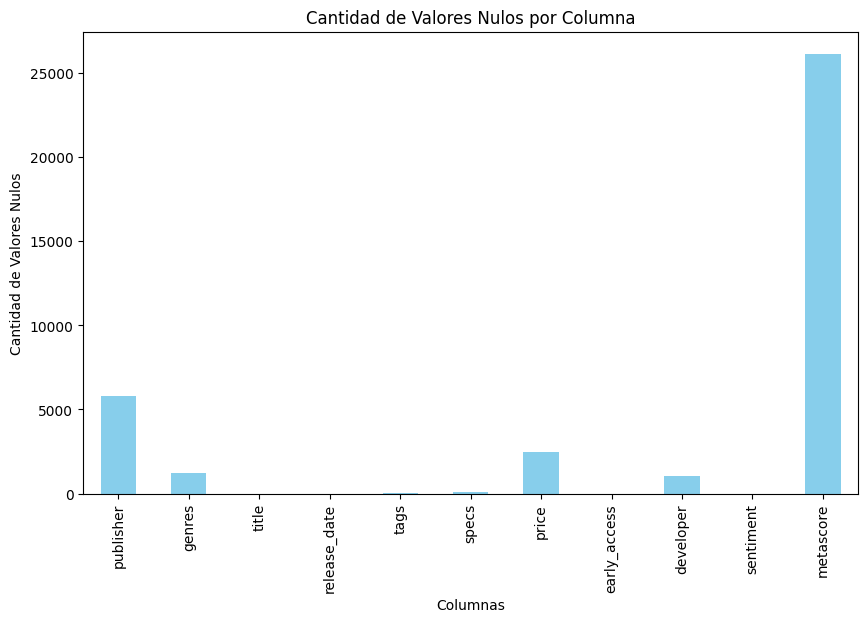

In [8]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6)) #tamaño del gráfico
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)  # se visualizan las barras de forma vertical
plt.show()

In [9]:
df[['price']]

,price
0,4.99
1,NaN
2,NaN
3,0.99
5,3.99
...,...
32129,1.99
32130,1.99
32131,4.99
32132,1.99


Reducimos el dataset a los registros que no tengan valores nan en la columna price, esta es la variable que se pretende predecir.

In [10]:
df_sin_nans = df.dropna(subset=["price"])
df=df_sin_nans

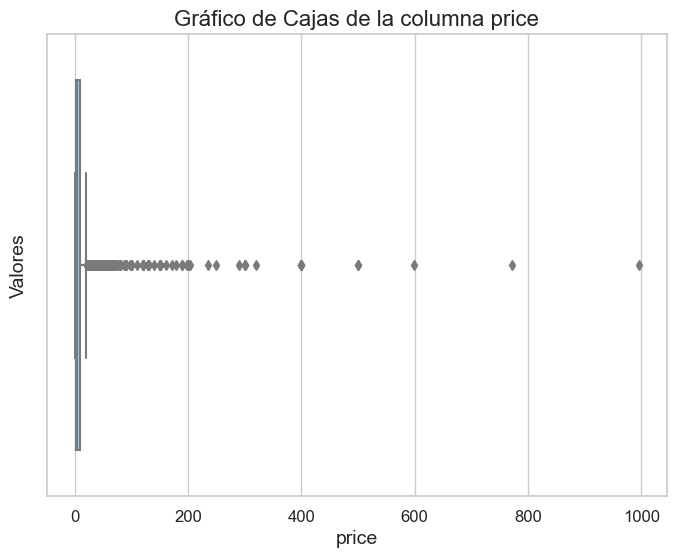

In [11]:

sns.set(style='whitegrid')  # Estilo de cuadrícula blanca

# gráfico de cajas
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["price"], palette='pastel')  # Paleta de colores suaves
plt.title(f'Gráfico de Cajas de la columna {"price"}', fontsize=16)
plt.xlabel("price", fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Del gráfico anterior se observa la presencia de outliers,se verá cuántos datos de este tipo hay en el dataset para determinar si se deberían considerar o no.

In [12]:
import numpy as np

Q1 = np.percentile(df["price"], 25)  # Primer cuartil (25%)
Q3 = np.percentile(df["price"], 75)  # Tercer cuartil (75%)
IQR = Q3 - Q1

infimo = Q1 - 1.5 * IQR
supremo = Q3 + 1.5 * IQR

print(f"Primer Cuartil (Q1): {Q1}")
print(f"Tercer Cuartil (Q3): {Q3}")
print(f"Rango Intercuartil (IQR): {IQR}")
print(f"Límite Inferior para Outliers: {infimo}")
print(f"Límite Superior para Outliers: {supremo}")

outliers = df[(df["price"] < infimo) | (df["price"] > supremo)]
min_outlier = outliers["price"].min()

print(f"Valor mínimo para considerar outliers: {min_outlier}")


Primer Cuartil (Q1): 2.99
Tercer Cuartil (Q3): 9.99
Rango Intercuartil (IQR): 7.0
Límite Inferior para Outliers: -7.51
Límite Superior para Outliers: 20.490000000000002
Valor mínimo para considerar outliers: 20.99


- El 50% de los datos se encuentra concentrado en un rango de 8 unidades.
- El límite inferior (infimo) del rango intercuartil es negativo, por lo que hay que observar adecuadamente los valores de la columna price.

In [13]:
positivos = (df["price"] > 0).sum()
negativos = (df["price"] < 0).sum()

print(f"Número de valores positivos: {positivos}")
print(f"Número de valores negativos: {negativos}")


Número de valores positivos: 25610
Número de valores negativos: 0


Dado que no se encuentran valores negativos en la columna "price" se entiende que esto es simplemente porque la mayoría de los valores án cerca de 0, sería entendible que el límite inferior del rango intercuartil pueda ser negativo, aunque no exista ningún valor del dataset que sea negativo.

Se verá ahora cuántos datos aparecen en el dataset mayores que 22, dado que a partir de aquí aparecen los outliers según la tabla anterior.

In [14]:
mayores_22= (df["price"] > 22).sum()
print(f"Número de datos mayores que 22 en la columna 'price': {mayores_22}")

Número de datos mayores que 22 en la columna 'price': 1731


In [15]:
df.shape

(25610, 11)

Dividimos el total de filas por el total de outliers que se encuentra en el dataset para ver si es relevante el porcentaje en cuanto a frecuencia

In [16]:
1731/29392 *100

5.889357648339684

la cantidad de outliers representa aproximadamente el 6% de los datos totales, se considerará eliminar estos valores.

In [17]:
df = df[df["price"] <= 22]

A continuación se visualiza un gráfico de cajas para observar la distribución de los datos dela columna "price".

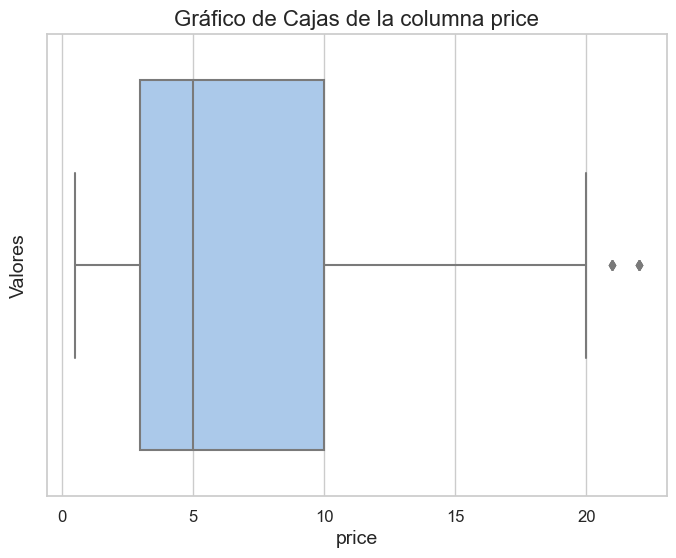

In [18]:

sns.set(style='whitegrid')  # Estilo de cuadrícula blanca

# gráfico de cajas
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["price"], palette='pastel')  # Paleta de colores suaves
plt.title(f'Gráfico de Cajas de la columna {"price"}', fontsize=16)
plt.xlabel("price", fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Aquí se corrobora que el 50% de los datos están entre el rango 2 y 10. El 70% de los precios son menores que 20 usd.

In [19]:
df.head()

,publisher,genres,title,release_date,tags,specs,price,early_access,developer,sentiment,metascore
0,Kotoshiro,Action,Lost Summoner Kitty,2018.0,Strategy,Single-player,4.99,0,Kotoshiro,sin_calificar,NaN
3,彼岸领域,Simulation,弹炸人2222,2017.0,Casual,Online Multi-Player,0.99,0,彼岸领域,sin_calificar,NaN
5,Trickjump Games Ltd,Free to Play,Battle Royale Trainer,2018.0,Free to Play,Steam Achievements,3.99,0,Trickjump Games Ltd,Mixed,NaN
6,None,Indie,SNOW - All Access Basic Pass,2018.0,Strategy,Steam Trading Cards,9.99,0,Poppermost Productions,sin_calificar,NaN
7,Poppermost Productions,RPG,SNOW - All Access Pro Pass,2018.0,Indie,In-App Purchases,18.99,0,Poppermost Productions,sin_calificar,NaN


se verá qué pasa con la columna "metascore"

In [20]:
print(df["metascore"].unique())   # se corrobora cuáles son las etiquetas

[nan 68. 66. 78. 76. 70. 53. 79. 63. 72. 64. 56. 75. 61. 67. 83. 49. 38.
 81. 85. 82. 52. 71. 65. 62. 84. 80. 77. 59. 74. 48. 87. 69. 34. 95. 43.
 54. 57. 73. 51. 60. 55. 92. 24. 46. 86. 58. 91. 44. 88. 41. 20. 39. 45.
 47. 40. 36. 90. 93. 50. 89. 32. 37. 42. 94.]


A simple vista no se encuentra algún tipo de columna del dataset que explique los valores nan de la columna "metascore". Por tal motivo se eliminará.

In [21]:
df.drop(columns=["metascore"],inplace=True) # se elimina dicha columna

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\165034532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["metascore"],inplace=True) # se elimina dicha columna


En el primer proceso de etl se cambiaron los valores nan por la categoría "sin_calificar"

In [22]:
print(df["sentiment"].unique())  # se corrobora cuáles son las etiquetas

['sin_calificar' 'Mixed' '1 user reviews' '3 user reviews'
 'Mostly Positive' '6 user reviews' '5 user reviews' '2 user reviews'
 'Positive' 'Very Positive' '8 user reviews' 'Overwhelmingly Positive'
 'Mostly Negative' '4 user reviews' '7 user reviews' '9 user reviews'
 'Very Negative' 'Overwhelmingly Negative' 'Negative']


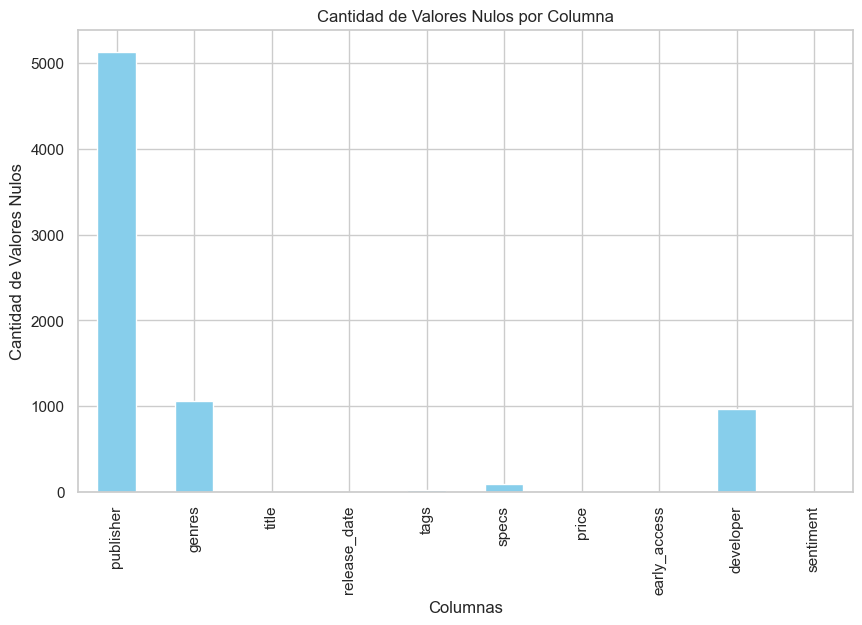

In [23]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6))  # Dimensiones del gráfico
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)  # barras verticaes
plt.show()

Se verificará qué porcentaje de nans se encuentra en la columna "publisher", dado que aparece una gran cantidad de ellos.

In [24]:
porcentaje_nulos = (df["publisher"].isnull().sum() / len(df["publisher"])) * 100
print(f"Porcentaje de valores nulos en la columna 'publisher': {porcentaje_nulos:.2f}%")

Porcentaje de valores nulos en la columna 'publisher': 21.50%


Se elimina el subconjunto de registros donde la columna "publisher" contiene valores nulos.

In [25]:
df.dropna(subset=["publisher"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\1886891301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["publisher"],inplace=True)


Se hará lo mismo con el resto de las columnas que contienen nans, según lo observado en el gráfico anterior.

In [26]:
df.dropna(subset=["genres"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\348327993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["genres"],inplace=True)


In [27]:
df.dropna(subset=["developer"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\2870847271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["developer"],inplace=True)


In [28]:
df.dropna(subset=["publisher"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\1886891301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["publisher"],inplace=True)


In [29]:
df.dropna(subset=["genres"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\348327993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["genres"],inplace=True)


In [30]:
df.dropna(subset=["specs"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\52031372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["specs"],inplace=True)


In [31]:
df.dropna(subset=["tags"],inplace=True)

C:\Users\Outlet VL\AppData\Local\Temp\ipykernel_6044\785789229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["tags"],inplace=True)


Se observan los formatos de cada columna

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17786 entries, 0 to 32133
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     17786 non-null  object 
 1   genres        17786 non-null  object 
 2   title         17786 non-null  object 
 3   release_date  17786 non-null  float64
 4   tags          17786 non-null  object 
 5   specs         17786 non-null  object 
 6   price         17786 non-null  float64
 7   early_access  17786 non-null  int32  
 8   developer     17786 non-null  object 
 9   sentiment     17786 non-null  object 
dtypes: float64(2), int32(1), object(7)
memory usage: 1.4+ MB


Se corrobora una vez más la cantidad de valores nan que aparecen en las columnas.

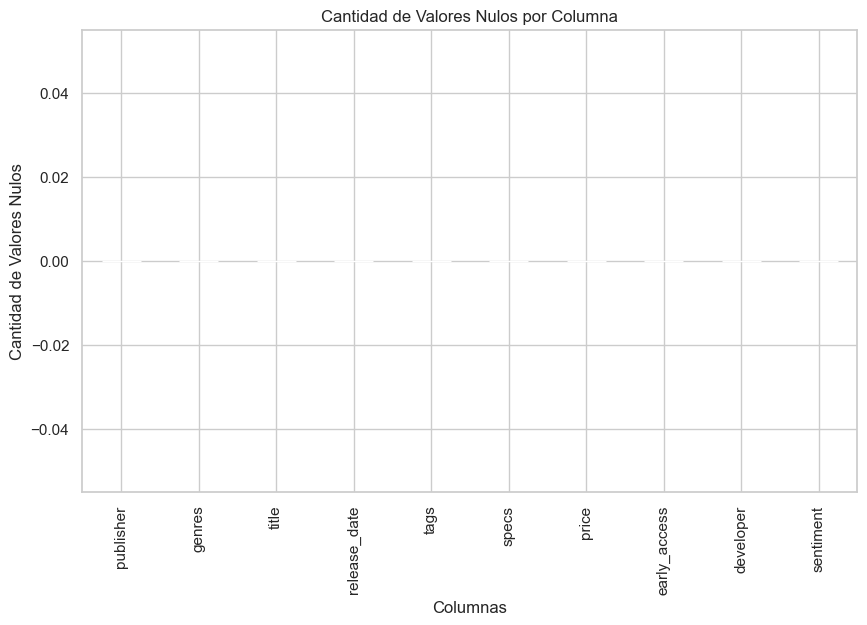

In [33]:
# se calcula la cantidad de valores nulos en cada columna
null_counts = df.isnull().sum()

# se genera el gráfico de barras
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de Valores Nulos')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=90)
plt.show()

Para conocer mejor el dataset, se visualizará un heatmap ( mapa de calor ) . Esto es para ver si existe alguna correlación entre columnas del dataset.

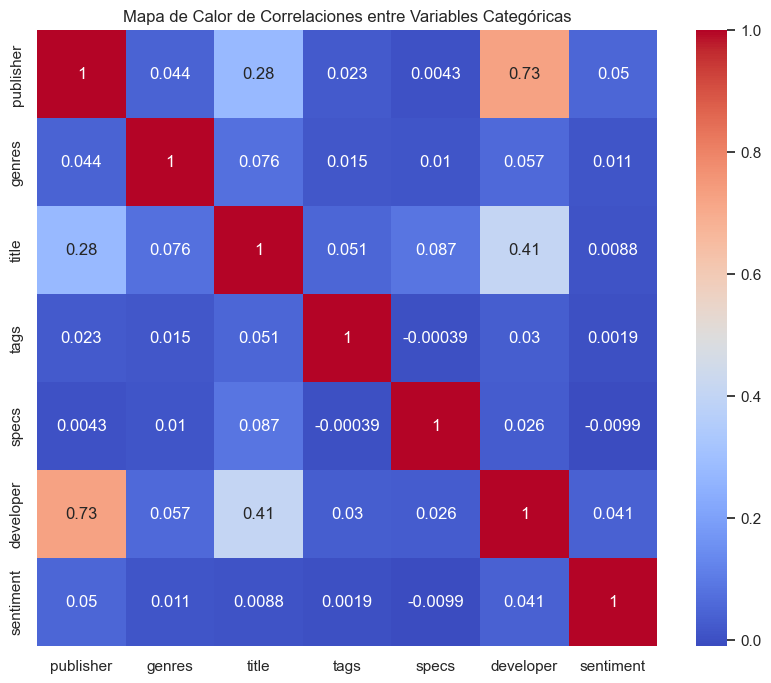

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlaciones entre variables categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
correlation_matrix = df[categorical_columns].apply(lambda x: x.factorize()[0]).corr()

# Crear un mapa de calor de las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Mapa de Calor de Correlaciones entre Variables Categóricas')
plt.show()



Parecen no haber variables fuertemente correlacionadas, salvo publisher y developer. De momento no se eliminará ninguna columna, si bien se podría considerar eliminar "publisher" o "developer".

Se separa el conjunto target "y" del resto de las variables del dataset "X".

In [35]:
X=df.drop("price",axis=1)
y=df['price']

Se eliminará la columna "title" en este caso para simplificar el modelo, también pensando en que el sentido común indica que aparentemente no hay una relación directa entre el título que ponga la persona y la predicción del precio. ( tal vez si la haya, pero en este caso no se estudiará ese caso ).

In [36]:
X=X.drop("title",axis=1)

Lo siguinte será codificar los datos, hay 3 posibilidades:
- Label encoding: No se consideró este caso dado que los algoritmos intentarán establecer orden de jerarquías con cada etiqueta, los modelos no han sido muy buenos en este caso.
- Integer encoding: Se utilizó esta opción por dos motivos:
   
1.   No existe relación de jerarquías entre las variables, se consideró preferible que los mismoa algoritmos busquen estas características.

2.   La cantidad de columnas sigue siendo la misma. Esto es una ventaja computacionalmente hablando.

- Get dummies ( One hot encoding): Si bien tal vez este método sería el más adecuado, el problema es que se generan muchas columnas y la pc que se está utilizando es limitada en recuersos computacionales.

#Columnas a codificar

In [37]:
#Lista de columnas a las que se aplicará  Encoding
columnas = ["publisher","genres", "tags", "specs","sentiment","developer","release_date"]

#Integer encoder

In [38]:
from sklearn.preprocessing import LabelEncoder

#Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

 #Aplicar Integer Encoding a las columnas seleccionadas
for col in columnas:
    X[col] = label_encoder.fit_transform(X[col])

 #Mostrar el DataFrame modificado
print(X)

       publisher  genres  release_date  tags  specs  early_access  developer  \
0           3191       1             8   269     26             0       4139   
3           6797      15             7    45     21             0       8730   
5           5927       9             8   108     29             0       7632   
7           4483      13             8   135      9             0       5774   
12          5401      15             8    98     28             0       6955   
...          ...     ...           ...   ...    ...           ...        ...   
32129        717       5             8    11     21             0        882   
32130       2379       1             8   250      4             0       5134   
32131       4970      17             8    45     22             0       6395   
32132       3268       1             8   251     26             0       4241   
32133       4934      10             7   203      8             0       8700   

       sentiment  
0             18  
3

#Test de distribución normal de los datos

Para ver si es posible aplicar un algoritmo de regresión lineal, primero se verá si se cumple una de sus hipótesis: las distribuciones de los datos debe ser normal.

In [39]:
import pandas as pd
from scipy.stats import shapiro

# Realizar el test de normalidad de Shapiro-Wilk para cada columna
normality_results = {}
for column in X.columns:
    stat, p_value = shapiro(X[column])
    normality_results[column] = {'statistic': stat, 'p-value': p_value}

# Imprimir los resultados del test
for column, result in normality_results.items():
    print(f"Column: {column}")
    print(f"Shapiro-Wilk Statistic: {result['statistic']:.4f}")
    print(f"P-value: {result['p-value']:.4f}")
    print("Is Normally Distributed: ", result['p-value'] > 0.05)
    print("=" * 40)



Column: publisher
Shapiro-Wilk Statistic: 0.9452
P-value: 0.0000
Is Normally Distributed:  False
Column: genres
Shapiro-Wilk Statistic: 0.9129
P-value: 0.0000
Is Normally Distributed:  False
Column: release_date
Shapiro-Wilk Statistic: 0.8452
P-value: 0.0000
Is Normally Distributed:  False
Column: tags
Shapiro-Wilk Statistic: 0.9276
P-value: 0.0000
Is Normally Distributed:  False
Column: specs
Shapiro-Wilk Statistic: 0.8254
P-value: 0.0000
Is Normally Distributed:  False
Column: early_access
Shapiro-Wilk Statistic: 0.2593
P-value: 0.0000
Is Normally Distributed:  False
Column: developer
Shapiro-Wilk Statistic: 0.9513
P-value: 0.0000
Is Normally Distributed:  False
Column: sentiment
Shapiro-Wilk Statistic: 0.8960
P-value: 0.0000
Is Normally Distributed:  False


c:\Users\Outlet VL\Desktop\programación\henry\Labs\semana_1\proyecto_semana1\venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Dado que las columnas del dataframe no siguen una distribución normal, se descarta automáticamente utilizar el método de  regresión multilineal.

#Estandarización de los datos

Se estandarizan los datos par tener una mejor visualización de los mismos y sobre todo para poder obtener una mejor performance de los algoritmos de machine learning.

In [40]:
# Se estandarizan los datos utilizando StandardScaler
scaler = StandardScaler()
X_n = scaler.fit_transform(X)

# Se convierte el arreglo numpy a un DataFrame de pandas, manteniendo el nombre de las columnas
X_n = pd.DataFrame(data=X_n, columns=X.columns)


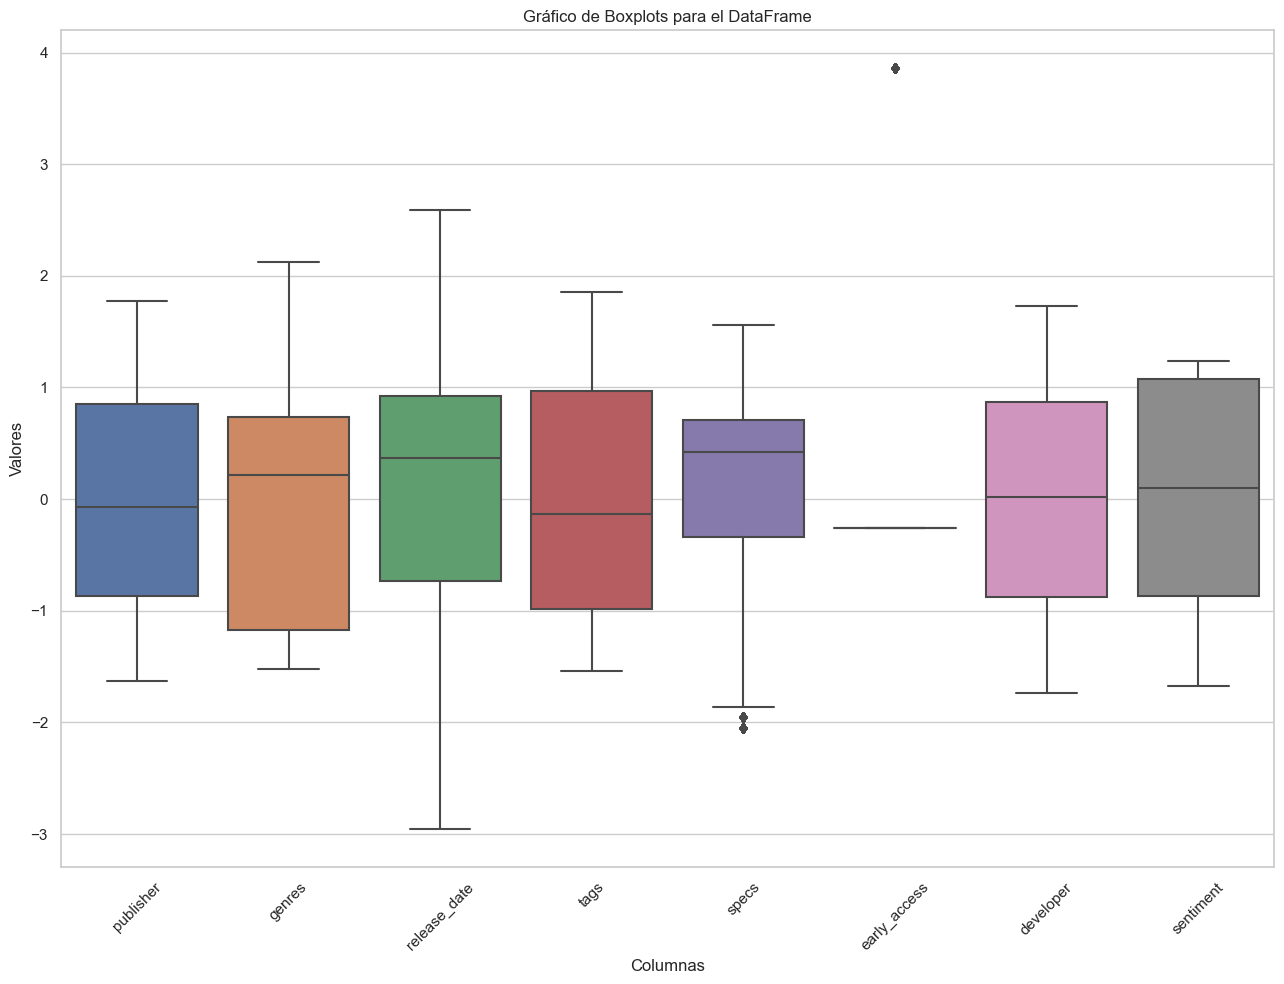

In [41]:
# Se definen los nombres de las columnas que se visualizarán
columnas = ["publisher","genres", "release_date", "tags", "specs", "early_access", "developer", "sentiment"]

# Crear un gráfico de boxplots
plt.figure(figsize=(13, 10))
sns.boxplot(data=X_n)
plt.title('Gráfico de Boxplots para el DataFrame')
plt.xlabel('Columnas')
plt.ylabel('Valores')
plt.xticks(range(len(columnas)), columnas, rotation=45)
plt.tight_layout()
plt.show()


la columna "early_acces" contiene outliers. Esta columna debería tener únicamente valores 0 y 1. Más adelante se determinará qué columnas se eliminarán.

#Get dummies

Dado que el dataset resultante de aplicar get dummies es muy grande y consume una cantidad de recursos computacionales considerable, he decidido descartar esta posibilidad aunque se comprende que sería lo más adecuado.

In [43]:
#Aplicar One-Hot Encoding a las columnas seleccionadas
#df_encoded = pd.get_dummies(X, columns=columnas)

#Mostrar el nuevo DataFrame con las columnas codificadas
#print(df_encoded.head())
#Xg=df_encoded

#Label encoding

In [44]:
#from sklearn.preprocessing import LabelEncoder

#Crear una instancia de LabelEncoder
#label_encoder = LabelEncoder()

 #Aplicar Label Encoding a las columnas seleccionadas
#for col in columnas:
    #X[col] = label_encoder.fit_transform(X[col])

 #Mostrar el nuevo DataFrame con las columnas codificadas
#print(X.head())

In [42]:
X=X_n

# Regresión polinómica

Se probó con distintos grados, en este caso el que mejor se ajustaba fue para n=3

In [63]:

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear características polinómicas
degree = 3  # Grado del polinomio
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Crear el modelo de Regresión Lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train_poly, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_poly)

# Calcular métricas del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Mean Squared Error (MSE): 28.00
Mean Absolute Error (MAE): 4.34
R-squared (R2): 0.04


Se observa que el 5% de la variable target y es explicada por las características en este modelo. Esto significa que este modelo no se ajusta adecuadamente.

# Importancia de las variables con random forest

Se verá qué columnas son más importantes a la hora de aplicar random forest.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# Crear el modelo de Random Forest
model = RandomForestRegressor(random_state=42)

# Ajustar el modelo a los datos
model.fit(X, y)

# Obtener la importancia relativa de las características
feature_importances = model.feature_importances_

# Crear un DataFrame para mostrar las importancias
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

# Ordenar el DataFrame por importancia en orden descendente
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Calcular el porcentaje acumulado de importancia
importance_df["Cumulative Importance"] = importance_df["Importance"].cumsum()

# Imprimir el DataFrame
print(importance_df)


Esta última tabla muestra la importancia de las características del dataset , según el modelo random forest. Se podrían eliminar las columnas "genres" "release_date" y "early_access"

In [59]:
X = X.drop(["genres", "release_date", "early_access"], axis=1)


Se utilizará esto para el algoritmo "Decision tree". Cabe alcarar que esta última conclusión no se aplica a los otros métodos
(sólo a random forest y a decision tree).

# Decision tree

In [53]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los hiperparámetros a explorar en la búsqueda en cuadrícula
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear el modelo de Árbol de Decisión
model = DecisionTreeRegressor(random_state=42)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores hiperparámetros:")
print(best_params)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = best_model.predict(X_train)

# Calcular métricas del modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Imprimir las métricas en el conjunto de entrenamiento
print("Métricas en el conjunto de entrenamiento:")
print(f"Mean Squared Error (MSE): {mse_train:.2f}")
print(f"Mean Absolute Error (MAE): {mae_train:.2f}")
print(f"R-squared (R2): {r2_train:.2f}")
print()

# Realizar predicciones en el conjunto de prueba
y_pred_test = best_model.predict(X_test)

# Calcular métricas del modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Imprimir las métricas en el conjunto de prueba
print("Métricas en el conjunto de prueba:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"R-squared (R2): {r2_test:.2f}")


Mejores hiperparámetros:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Métricas en el conjunto de entrenamiento:
Mean Squared Error (MSE): 20.52
Mean Absolute Error (MAE): 3.46
R-squared (R2): 0.32

Métricas en el conjunto de prueba:
Mean Squared Error (MSE): 24.80
Mean Absolute Error (MAE): 3.85
R-squared (R2): 0.15


Mejores hiperparámetros:
'max_depth': 10
'min_samples_leaf'
4, 'min_samples_split': 10  

# K-means

Se intentará ver si es posible separar los datos en clusters. La intención es ver si es posible obtener otras etiquetas que ayuden a obtener mejores resultados con los algoritmos de regresión.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mean Squared Error (MSE): 23.53
Mean Absolute Error (MAE): 3.79
R-squared (R2): 0.21


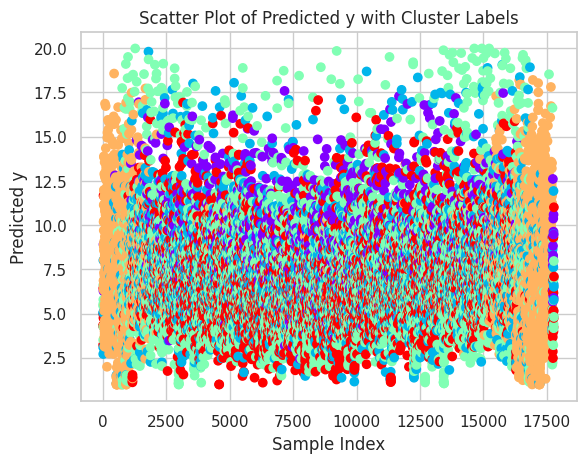

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Aplicar KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)  # X es tu conjunto de datos

# Agregar etiquetas de cluster como nueva columna en el DataFrame original
X["cluster_label"] = cluster_labels

# Definir el modelo de Random Forest
model = RandomForestRegressor(n_estimators=50, random_state=42)

# Realizar predicciones utilizando validación cruzada
y_pred = cross_val_predict(model, X, y, cv=5)

# Calcular métricas de evaluación
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Imprimir las métricas
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')

# Crear un nuevo DataFrame con las etiquetas de cluster
cluster_df = pd.DataFrame({"cluster_label": cluster_labels})

# Concatenar el nuevo DataFrame con el DataFrame original
new_dataset = pd.concat([X, cluster_df], axis=1)

# Crear un gráfico de dispersión de los datos coloreado por etiquetas de clúster
plt.scatter(X.index, y_pred, c=cluster_labels, cmap='rainbow')
plt.xlabel('Sample Index')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Predicted y with Cluster Labels')
plt.show()


# PCA

Se aplicará PCA con la intención de buscar las características más importantes del dataset, para ver si es factible hacer una reducción de dimensionalidad.

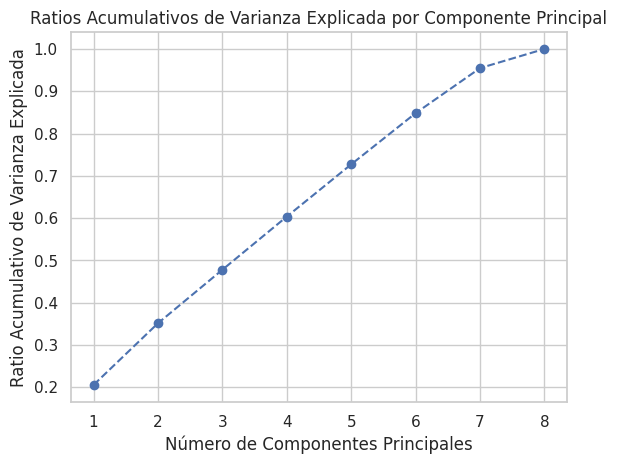

Componente Principal 1: Ratio Acumulativo de Varianza Explicada = 0.2054
Componente Principal 2: Ratio Acumulativo de Varianza Explicada = 0.3513
Componente Principal 3: Ratio Acumulativo de Varianza Explicada = 0.4778
Componente Principal 4: Ratio Acumulativo de Varianza Explicada = 0.6035
Componente Principal 5: Ratio Acumulativo de Varianza Explicada = 0.7271
Componente Principal 6: Ratio Acumulativo de Varianza Explicada = 0.8481
Componente Principal 7: Ratio Acumulativo de Varianza Explicada = 0.9547
Componente Principal 8: Ratio Acumulativo de Varianza Explicada = 1.0000
Número de componentes para explicar al menos 95.0% de varianza acumulada: 7


In [64]:

# Reducción de dimensionalidad con PCA
pca = PCA()  # se quieren ver todas las componentes
X_pca = pca.fit_transform(X)

# Gráfico de los ratios acumulativos de varianza explicada por cada componente principal
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Ratio Acumulativo de Varianza Explicada')
plt.title('Ratios Acumulativos de Varianza Explicada por Componente Principal')
plt.show()

# Se muestran los ratios de varianza acumulados
for i, cum_ratio in enumerate(cumulative_variance_ratio, start=1):
    print(f'Componente Principal {i}: Ratio Acumulativo de Varianza Explicada = {cum_ratio:.4f}')

# Se calcula la cantidad de componentes necesarias para explicar cierto porcentaje de varianza
threshold_cumulative_variance = 0.95  # Cambia este valor según tus necesidades
num_components_needed = next(i for i, cum_ratio in enumerate(cumulative_variance_ratio) if cum_ratio >= threshold_cumulative_variance) + 1
print(f'Número de componentes para explicar al menos {threshold_cumulative_variance * 100:.1f}% de varianza acumulada: {num_components_needed}')




Se observa, por ejemplo, que 7 componentes o autovectores encontrados explican más del 95 % de los datos, con 6 componentes se obtiene más del 85% de los mismos. Se considera entonces que no es muy conveniente aplicar este método en este caso dado que se necesitan casi la misma cantidad de variables que se están manejando sin aplicar este método.

#Random forest

Se puede aplicar una grilla para ajustar hiperparámetros, la intención es buscar los que mejor se ajusten al modelo

Grilla

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Crear y entrenar el modelo de Random Forest
model = RandomForestRegressor()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir la cuadrícula de hiperparámetros a probar
param_grid = {
    'n_estimators': [ 20, 50, 100],
    'max_depth': [None, 10, 15, 25],
}

# Realizar la búsqueda de parámetros utilizando GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio en el conjunto de prueba:", mse)

# Imprimir los mejores parámetros
print("Mejores parámetros:", best_params)


Error cuadrático medio en el conjunto de prueba: 23.938353886225254
Mejores parámetros: {'max_depth': 15, 'n_estimators': 50}


Aplicamos estos parámetros al modelo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de Random Forest
model = RandomForestRegressor(n_estimators=50,max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')

# Calcular el número de características utilizadas por el modelo
num_features = X_train.shape[1]
# Calcular el número de muestras en el conjunto de prueba
num_samples = len(y_test)

# Calcular el coeficiente de determinación ajustado (Adjusted R-squared)
adjusted_r2 = 1 - ((1 - r2) * (num_samples - 1)) / (num_samples - num_features - 1)

# Imprimir el coeficiente de determinación ajustado
print(f'Adjusted R-squared: {adjusted_r2:.2f}')

# Calcular el número de muestras en el conjunto de prueba
num_samples = len(y_test)

# Imprimir el coeficiente de determinación ajustado
print(f'Adjusted R-squared: {adjusted_r2:.2f}')


Mean Squared Error (MSE): 24.13
Mean Absolute Error (MAE): 3.91
R-squared (R2): 0.17
Adjusted R-squared: 0.17
Adjusted R-squared: 0.17


# SVM

Se intentará determinar qué nucleo es más conveniente utilizar para este dataset. Se descartaron el polinomial y el lineal.

In [46]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Supongamos que tienes tu conjunto de datos X y y

# Definir los parámetros a buscar en la búsqueda de hiperparámetros
param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Crear el modelo de SVR
model = SVR()

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Realizar la búsqueda de hiperparámetros en los datos normalizados
grid_search.fit(X, y)

# Mostrar los mejores parámetros y el mejor score obtenido
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor MSE:", -grid_search.best_score_)



Mejores hiperparámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor MSE: 30.816651456100004


# Gradient Boosting Regressor

Se genera una grilla para buscar los mejores hiperparámetros.

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que tienes tu DataFrame df con tus datos
# X = df.drop(columns=['y']).values  # Convierte el DataFrame en una matriz
# y = df['y'].values  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Crear el modelo de Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular métricas del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas y los mejores hiperparámetros
print("Mejores hiperparámetros:", best_params)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Mean Squared Error (MSE): 20.48
Mean Absolute Error (MAE): 3.52
R-squared (R2): 0.30


# Mejor modelo

Finalmente se intentará ver qué modelo podría ofrecer mejores métricas, se compararán "linear Regression", "SVR",  "Random forest (como regersor ) y Gradient Boosting.

Model: SVR
Mean Squared Error (MSE): 30.05
Root Mean Squared Error (RMSE): 5.48
Mean Absolute Error (MAE): 4.12
R-squared (R2): -0.03


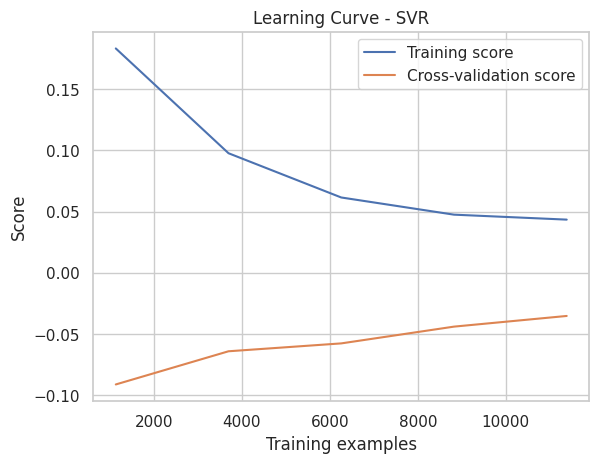

Model: DecisionTreeRegressor
Mean Squared Error (MSE): 24.76
Root Mean Squared Error (RMSE): 4.98
Mean Absolute Error (MAE): 3.84
R-squared (R2): 0.15


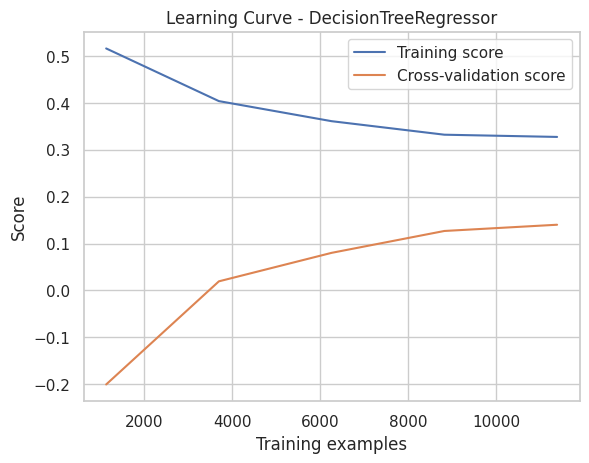

Model: RandomForestRegressor
Mean Squared Error (MSE): 22.25
Root Mean Squared Error (RMSE): 4.72
Mean Absolute Error (MAE): 3.72
R-squared (R2): 0.24


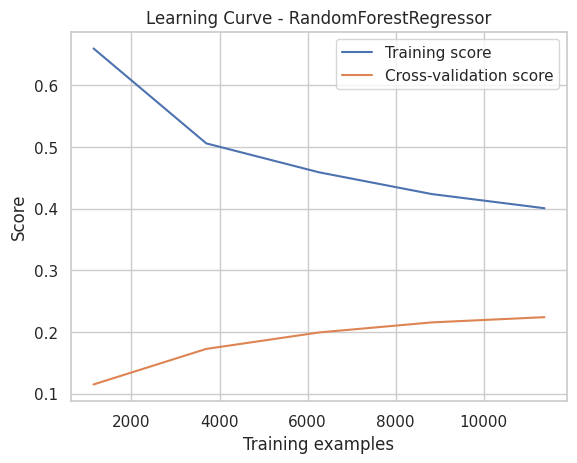

Model: GradientBoostingRegressor
Mean Squared Error (MSE): 20.48
Root Mean Squared Error (RMSE): 4.53
Mean Absolute Error (MAE): 3.52
R-squared (R2): 0.30


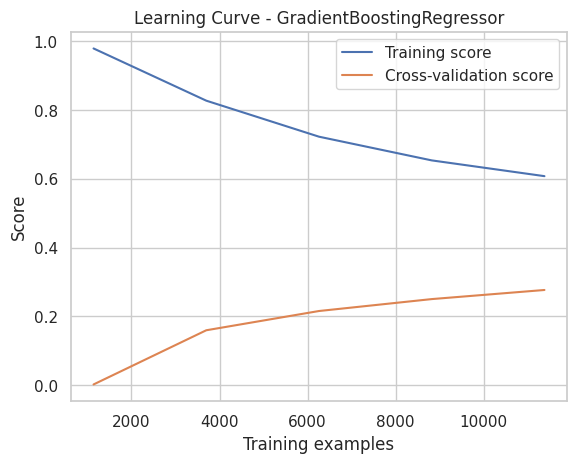

In [64]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear una lista de modelos a probar
models = [
    SVR(kernel='rbf', C=10, gamma='auto'),
    DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=42),
    RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=42)
]

best_model = None
best_r2 = -float('inf')

for model in models:
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas del modelo
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Imprimir las métricas del modelo actual
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.2f}")

    # Generar una curva de aprendizaje para analizar el sobreajuste
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Graficar la curva de aprendizaje
    plt.figure()
    plt.title(f"Learning Curve - {model.__class__.__name__}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

    print("=" * 40)



Se puede observar que, en todos los gráficos, las curvas de aprendizaje se acercan entre sí, y la de validación cruzada está por debajo de la de entrenamiento. Dado esto, es posible que no haya un problema de sobreajuste. Sin embargo, las curvas parecieran tender a converger a puntajes bajos, esto indica que dichos modelos no están captando adecuadamente las características del dataset, tal y como indican el resto de las métricas.

#Pese a todo esto, se concluye que Gradient Boosting Regressor ofrece las mejores métricas en este caso, por lo que se utilizará este modelo.

También se presenta la aplicación del algoritmo de redes neuronales, dado que es necesario buscar más hiperparámetros y por falta de tiempo, se dejará excluido de este estudio, aunque debería considerarse.

In [60]:
import tensorflow as tf


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un modelo de red neuronal más complejo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),  # Regularización dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Regularización dropout
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Capa de salida lineal
])

# Compilar el modelo con un optimizador y una tasa de aprendizaje ajustables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Entrenar el modelo con más épocas y tamaño de lote pequeño
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")



Epoch 1/100
356/356 - 1s - loss: 34.0486 - val_loss: 30.0638 - 1s/epoch - 4ms/step
Epoch 2/100
356/356 - 1s - loss: 30.8159 - val_loss: 29.6145 - 515ms/epoch - 1ms/step
Epoch 3/100
356/356 - 1s - loss: 30.3695 - val_loss: 29.3345 - 508ms/epoch - 1ms/step
Epoch 4/100
356/356 - 1s - loss: 30.1228 - val_loss: 28.8254 - 562ms/epoch - 2ms/step
Epoch 5/100
356/356 - 1s - loss: 29.8352 - val_loss: 28.9413 - 561ms/epoch - 2ms/step
Epoch 6/100
356/356 - 1s - loss: 29.5625 - val_loss: 28.8906 - 575ms/epoch - 2ms/step
Epoch 7/100
356/356 - 1s - loss: 29.5073 - val_loss: 29.1119 - 660ms/epoch - 2ms/step
Epoch 8/100
356/356 - 1s - loss: 29.4090 - val_loss: 28.4979 - 657ms/epoch - 2ms/step
Epoch 9/100
356/356 - 1s - loss: 29.1671 - val_loss: 28.4654 - 585ms/epoch - 2ms/step
Epoch 10/100
356/356 - 1s - loss: 29.2012 - val_loss: 28.4294 - 566ms/epoch - 2ms/step
Epoch 11/100
356/356 - 1s - loss: 29.1491 - val_loss: 28.4953 - 569ms/epoch - 2ms/step
Epoch 12/100
356/356 - 1s - loss: 29.1089 - val_loss: 2

In [46]:
import pickle

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# se entrena el modelo
model = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# se guarda el modelo en formato pickle
model_filename = 'gradient_boosting_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
